### Student Activity: Financial Forecasting Part I

This program executes a single simulation of stock price trajectory over the next `252 * 3` trading days (or 3 years of trading) for `TSLA` stock, based on a normal probability distribution of historical daily returns derived from the sample mean and standard deviation.

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

### Check Available Tickers from Alpaca Markets API

In [3]:
# Get all Assets
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
tradeable

[Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NASDAQ',
     'id': '2a5db6a2-c035-46cc-840f-fa519740a9b5',
     'marginable': True,
     'name': 'LifeSci Acquisition Corp. Common Stock',
     'shortable': False,
     'status': 'active',
     'symbol': 'LSAC',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': True,
     'exchange': 'NYSE',
     'id': '49b90cdc-f6f5-4a7c-807a-ed172e6017af',
     'marginable': True,
     'name': 'American Express Company',
     'shortable': True,
     'status': 'active',
     'symbol': 'AXP',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': True,
     'exchange': 'NYSE',
     'id': 'f85c0ede-3556-4d0b-9e0c-4ffc2425044d',
     'marginable': True,
     'name': 'Diageo plc',
     'shortable': True,
     'status': 'active',
     'symbol': 'DEO',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NYSE',
     'i

In [4]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head(10))

,symbol
0,LSAC
1,AXP
2,OIL
3,CCA
4,CY
5,NFO
6,CBPX
7,GRSH_DELISTED
8,N014776_DELISTED
9,KOR


### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [5]:
# Set the ticker
ticker = "TSLA"

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Format end_date and start_date with isoformat
end_date = pd.Timestamp(end_date, tz="America/New_York").isoformat()
start_date = pd.Timestamp(start_date, tz="America/New_York").isoformat()

# Get 1 year's worth of historical data for TSLA
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

TSLA                                     
                             open     high       low   close    volume
2019-05-07 00:00:00-04:00  256.80  257.210  245.1000  247.06   9542822
2019-05-08 00:00:00-04:00  246.94  250.599  244.2000  244.76   5757805
2019-05-09 00:00:00-04:00  242.00  243.680  236.9434  241.98   6455536
2019-05-10 00:00:00-04:00  239.75  241.990  236.0200  239.51   6716345
2019-05-13 00:00:00-04:00  232.01  232.470  224.5000  227.01  10159046

### Drop Extraneous Levels and Columns

In [6]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)

# Use the drop function to drop extra columns
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

df.head()

,close
2019-05-07,247.06
2019-05-08,244.76
2019-05-09,241.98
2019-05-10,239.51
2019-05-13,227.01


### Calculate Daily Returns

In [7]:
# Use the `pct_change` function to calculate daily returns of TSLA
daily_returns = df.pct_change()
daily_returns.head()

,close
2019-05-07,NaN
2019-05-08,-0.009309
2019-05-09,-0.011358
2019-05-10,-0.010207
2019-05-13,-0.052190


### Calculate Value of Average Daily Returns

In [8]:
# Use the `mean` function to calculate the mean of daily returns for TSLA
avg_daily_return = daily_returns.mean()['close']
avg_daily_return

0.005764320559715032

### Calculate Value of Standard Deviation of Daily Returns

In [9]:
# Use the `std` function to calculate the standard deviation of daily returns for TSLA
std_dev_daily_return = daily_returns.std()['close']
std_dev_daily_return

0.04863183163111945

### Run the Monte Carlo Simulation and Save Results to DataFrame

In [10]:
# Set number of trading days and get last closing price of TSLA from DataFrame
num_trading_days = 252 * 3
tsla_last_price = df['close'][-1]

# Initialize the simulated prices list with the last closing price of TSLA
simulated_tsla_prices = [tsla_last_price]

# Simulate the returns for 252 * 3 trading days
for i in range(num_trading_days):
    # Calculate the simulated price using the last price within the list
    simulated_price = simulated_tsla_prices[-1] * (1 + np.random.normal(avg_daily_return, std_dev_daily_return))
    # Append the simulated price to the list
    simulated_tsla_prices.append(simulated_price)
    
# Create a DataFrame of the simulated prices
simulated_price_df = pd.DataFrame({
    "Simulated TSLA Prices": simulated_tsla_prices
})

# Print head of DataFrame
simulated_price_df.head()

,Simulated TSLA Prices
0,782.450000
1,710.722183
2,725.736262
3,685.806374
4,646.845847


### Plot the Simulated Stock Price Trajectory for TSLA over the Next 3 Years (252 * 3) of Trading Days

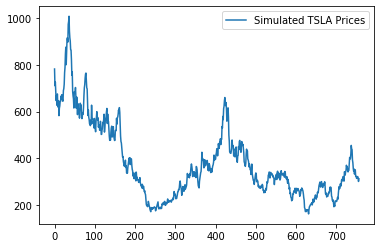

In [11]:
# Use the `plot` function to plot the trajectory of TSLA stock based on a (252 * 3) trading day simulation
simulated_price_df.plot()

### Calculate Daily Returns of Simulated Stock Prices for TSLA

In [12]:
# Use the `pct_change` function to calculate daily returns of simulated stock prices for TSLA
simulated_daily_returns = simulated_price_df.pct_change()
simulated_daily_returns.head()

,Simulated TSLA Prices
0,NaN
1,-0.091671
2,0.021125
3,-0.055020
4,-0.056810


### Calculate the Cumulative Returns of Simulated Stock Prices for TSLA

In [13]:
# Use the `cumprod` function to calculate the cumulative returns of simulated stock prices for TSLA
simulated_cumulative_returns = (1 + simulated_daily_returns).cumprod()
simulated_cumulative_returns.head()

,Simulated TSLA Prices
0,NaN
1,0.908329
2,0.927518
3,0.876486
4,0.826693


### Calculate the Cumulative Profits/Losses of Simulated Stock Prices for TSLA

In [14]:
# Multiply an initial investment by the cumulative returns of simulative stock prices to
# return the progression of cumulative returns in terms of money
initial_investment = 10000
cumulative_pnl = initial_investment * simulated_cumulative_returns
cumulative_pnl.head()

,Simulated TSLA Prices
0,NaN
1,9083.292008
2,9275.177483
3,8764.858759
4,8266.928844


### Plot the Cumulative Profits/Losses of `$10,000` in TSLA Over the Next 3 Years (252 * 3) of Trading Days

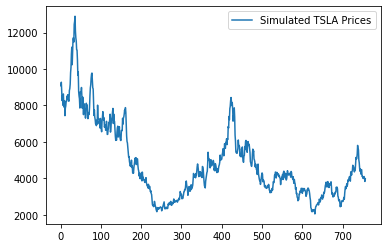

In [15]:
# Use the 'plot' function to create a chart of the cumulative profits/losses
cumulative_pnl.plot()